<a href="https://colab.research.google.com/github/RayGone/DeepWeeds/blob/main/ResNet50-Frozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
# !pip install tensorflow-datasets -q
# import tensorflow_datasets as tfds
# ds = tfds.load('deep_weeds', split='train')
# assert isinstance(ds, tf.data.Dataset)
# print(ds)

## Downloading DeepWeeds Data

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
!gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj

Downloading...
From (original): https://drive.google.com/uc?id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
From (redirected): https://drive.google.com/uc?id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj&confirm=t&uuid=658672d0-0dfc-4866-98f0-b8e7af55ff1d
To: /content/images.zip
100% 492M/492M [00:08<00:00, 58.4MB/s]


In [ ]:
!unzip -qq images.zip -d images

In [ ]:
import pandas as pd

data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv')
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [ ]:
data_info[['Species','Label']].value_counts()

Species         Label
Negative        8        9106
Chinee apple    0        1125
Siam weed       6        1074
Lantana         1        1064
Prickly acacia  4        1062
Parkinsonia     2        1031
Parthenium      3        1022
Snake weed      7        1016
Rubber vine     5        1009
dtype: int64

In [ ]:
# prompt: train test split using data_info

train_data = data_info.sample(frac=0.8, random_state=999)
test_data = data_info.drop(train_data.index)

train_data.head(10)


,Filename,Label,Species
12263,20180105-104343-1.jpg,8,Negative
17144,20180322-114749-1.jpg,8,Negative
7653,20171113-102008-1.jpg,5,Rubber vine
11166,20171220-090841-2.jpg,8,Negative
6256,20171025-091838-1.jpg,3,Parthenium
11525,20171220-095959-2.jpg,8,Negative
1447,20170405-155115-0.jpg,0,Chinee apple
14855,20180112-101736-1.jpg,8,Negative
16308,20180125-131458-3.jpg,8,Negative
6894,20171102-122946-2.jpg,2,Parkinsonia


## Creating Dateset ImageGenerator

In [ ]:
import os
import shutil

base_dir = '/content/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

os.mkdir(train_dir)
os.mkdir(validation_dir)

## Organizing Training Data
for index, row in train_data.iterrows():
  filename = row['Filename']
  label = row['Label']
  path = os.path.join(train_dir,str(label))

  source = os.path.join(base_dir,filename)
  target = os.path.join(path,filename)
  # print(source,target)

  if not os.path.exists(path):
    os.mkdir(path)

  shutil.move(source,target)


## Organizing Test Data
for index, row in test_data.iterrows():
  filename = row['Filename']
  label = row['Label']
  path = os.path.join(validation_dir,str(label))

  source = os.path.join(base_dir,filename)
  target = os.path.join(path,filename)
  # print(source,target)

  if not os.path.exists(path):
    os.mkdir(path)

  shutil.move(source,target)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=IMG_SIZE)
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=10,
                                                         class_mode  = 'categorical',
                                                         target_size = IMG_SIZE)

Found 14007 images belonging to 9 classes.
Found 3502 images belonging to 9 classes.


## Building Model

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### 1. ResNet50 - Frozen

In [ ]:
# prompt: code to implement resned

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import ResNet50V2

train_resnet = False

# Load the ResNet50 model with weights pre-trained on ImageNet.
base_model = ResNet50V2(weights='imagenet', include_top=False)
base_model.trainable = False

input_shape = list(IMG_SIZE)
input_shape.append(3)
# Define the input layer.
inputs = keras.Input(shape=input_shape)

# Normalize the input.
x = layers.Rescaling(1, offset=-1)(inputs)

# Pass the input through the pre-trained ResNet50 model.
x = base_model(x, training=train_resnet)

# # Add a dropout layer with a rate of 0.1.
if train_resnet:
  x = layers.Dropout(0.1)(x)

# Add a global average pooling layer.
x = layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation.
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout layer with a rate of 0.2.
x = layers.Dropout(0.2)(x)

# Add a final output layer with 10 units and softmax activation.
outputs = layers.Dense(9, activation='softmax')(x)

# Create the model.
model = keras.Model(inputs=inputs, outputs=outputs)

# Print the model summary.
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0   

In [ ]:
from tensorflow.keras.optimizers import RMSprop, AdamW

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-5,  weight_decay=3e-3),
          metrics=['accuracy'])

Epoch 1/30
701/701 [==============================] - 62s 83ms/step - loss: 1.3517 - accuracy: 0.5527 - val_loss: 1.0580 - val_accuracy: 0.6219
Epoch 2/30
701/701 [==============================] - 60s 86ms/step - loss: 0.9962 - accuracy: 0.6540 - val_loss: 0.9042 - val_accuracy: 0.6728
Epoch 3/30
701/701 [==============================] - 58s 82ms/step - loss: 0.8729 - accuracy: 0.6929 - val_loss: 0.8327 - val_accuracy: 0.6933
Epoch 4/30
701/701 [==============================] - 57s 81ms/step - loss: 0.8033 - accuracy: 0.7206 - val_loss: 0.7846 - val_accuracy: 0.7164
Epoch 5/30
701/701 [==============================] - 57s 81ms/step - loss: 0.7470 - accuracy: 0.7367 - val_loss: 0.7487 - val_accuracy: 0.7293
Epoch 6/30
701/701 [==============================] - 57s 81ms/step - loss: 0.7021 - accuracy: 0.7580 - val_loss: 0.7289 - val_accuracy: 0.7336
Epoch 7/30
701/701 [==============================] - 56s 80ms/step - loss: 0.6642 - accuracy: 0.7700 - val_loss: 0.7088 - val_accuracy:

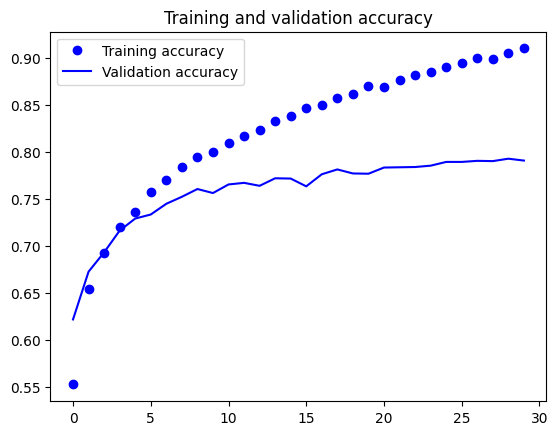

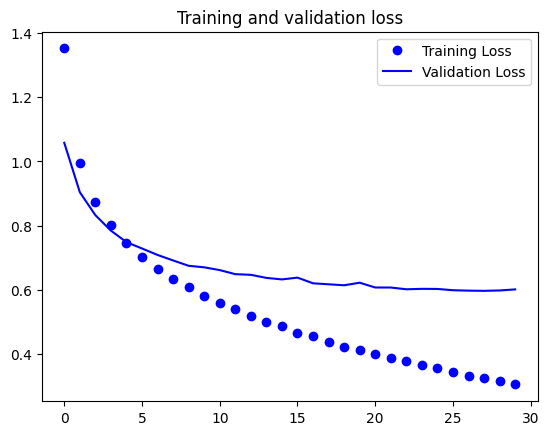

In [ ]:
# Constant for epochs
EPOCHS = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Train the model
history = model.fit(
      train_generator,
      #steps_per_epoch=100,
      epochs=EPOCHS,
      validation_data=validation_generator,
      #validation_steps=50,  # 1000 images = batch_size * steps
      callbacks=[callback]
    )



# Plot training results
plot_loss_acc(history)